# DATASCI W261, Machine Learning at Scale
--------
#### Assignement:  week \#4
#### Shih Yu Chang
### Due: 2016-09-27, 8AM PST

# HW 4.0. 
What is MrJob? How is it different to Hadoop MapReduce? 
What are the mapper_init, mapper_final(), combiner_final(), reducer_final() methods? When are they called?




#### What is MrJob? How is it different to Hadoop MapReduce?

mrjob is an open-source Python  package, originally developed by Yelp, that helps write and run Hadoop Streaming jobs. mrjob fully supports Amazon's Elastic MapReduce (EMR) service, which allows buying time on a Hadoop cluster on an hourly basis. It also works with one's local Hadoop cluster. mrjob can also be run directly through Python, for testing/debugging purpose. mrjob is a utility library that simplifies writing and running Hadoop Streaming jobs, developer doesn't need to handle many lower level tasks in Hadoop Streaming such as MapReduce job chaining, configuration management. Therefore, users can pay more attention to writing the analysis procedures for the data pipeline. Hadoop MapReduce is the execution platform that mrjob sends the MapReduce job to, and receives results from.


#### What are the mappint_init(), mapper_final(), combiner_final(), reducer_final() methods? When are they called?


mapper_init(): lets users perform the job needs to be executed before the mapper starts processing any input.
mapper_final(): When Hadoop Streaming stops sending data to the map task, mrjob calls mapper_final(). That function emits the local aggregation result for this task, which is a much smaller size of output lines than the mapper would have output.
combiner_final(): This function runs a user-defined action, when Hadoop Streaming stops sending data to the combine task
reducer_final():  Theis method runs a user-defined action, when Hadoop Streaming stops sending data to the reduce task






# HW 4.1
What is serialization in the context of MrJob or Hadoop? 
When it used in these frameworks? 
What is the default serialization mode for input and outputs for MrJob? 

#### What is serialization in the context of mrjob or Hadoop?
Serialization is the procedure of turning structured objects into bits stream. 
In the context of Hadoop, serialization is leveraged for compression 
to reduce network communication loads. Different from  mrjob, where serialization 
is leveraged to convienentally pass structured objects 
between mapper, reducer, etc. methods.

#### When is it used in these frameworks?
Serialization is used by I/O management and data transfer, where job input/output with different format between mrjob and Hadoop are streaming by the data analysis pipeline during the job execution.

#### What is the default serialization mode for input and output for mrjob?
For input, the default serialization mode is raw text (RawValueProtocol), 
and for output (and internal), the default mode is JSON format (JSONProtocol).

# HW 4.2: Recall the Microsoft logfiles data from the async lecture.

In [53]:
%%writefile HW4_2.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
 
class LogTransformation(MRJob):
    # visitor ID
    visitor = None
    
    def mapper(self, _, line):        
        # time of mapper being called
        self.increment_counter('HW4_2', 'lines', 1)
        # only emit lines start with C and V
        line = line.strip()
        if line[0] not in ['C', 'V']:
            return
        # process C and V lines
        if line[0] == 'C':            
            # get the visitor ID
            self.visitor = 'C,%s' %line.split(',')[2]            
        else:
            # emit the required output 
            yield line, self.visitor   
    
    # MapReduce steps
    def steps(self):
        return [MRStep(mapper=self.mapper)]

if __name__ == '__main__':
    LogTransformation.run()

Overwriting HW4_2.py


In [54]:
# run the job locally
!python HW4_2.py anonymous-msweb.data > HW4_2_results
# results sample
!head -10 HW4_2_results

Using configs in /etc/mrjob.conf
Creating temp directory /tmp/HW4_2.cloudera.20160922.052717.154142
Running step 1 of 1...
Counters: 1
	HW4_2
		lines=131666
Streaming final output from /tmp/HW4_2.cloudera.20160922.052717.154142/output...
Removing temp directory /tmp/HW4_2.cloudera.20160922.052717.154142...
"V,1000,1"	"C,10001"
"V,1001,1"	"C,10001"
"V,1002,1"	"C,10001"
"V,1001,1"	"C,10002"
"V,1003,1"	"C,10002"
"V,1001,1"	"C,10003"
"V,1003,1"	"C,10003"
"V,1004,1"	"C,10003"
"V,1005,1"	"C,10004"
"V,1006,1"	"C,10005"


# HW 4.3: Find the 5 most frequently visited pages using MrJob from the output of 4.2 (i.e., transfromed log file).

In [73]:
%%writefile HW4_3.py
#!/usr/bin/python
from mrjob.job import MRJob 
from mrjob.step import MRStep
from mrjob.conf import combine_dicts
import heapq

 
class Top5VisitedPage(MRJob):
   
    def jobconf(self):
        orig_jobconf = super(Top5VisitedPage, self).jobconf()
        
        custom_jobconf = {
            'mapred.map.tasks' : 5,
            'mapred.reduce.tasks' : 5
        }

        return combine_dicts(orig_jobconf, custom_jobconf) 
    
    # Extract the pages from HW4.2 results and yield for counting
    def mapper_page_count(self, dummy, line): 
        pID = line.strip().split(',')[1]
        yield pID.strip(), 1
    
    # identity mapper used to sort in MRJob
    def mapper_page_top5(self, key, value):
        yield key, value
    
    # Combiner for the page count
    def combiner_page_count(self, page, count):
        yield page, sum(count)

    # combine sums for each page and change the key, value to sort on count
    def reducer_page_count(self, page, count):
        yield None, (sum(count), page)
        
    # use a heap sort to yield the top5 pages by count
    def reducer_page_top5(self, _, page_count):
        for count, page in heapq.nlargest(5, page_count):
            yield page, count
            
    # define the execution steps 
    def steps(self):
        return[MRStep(mapper=self.mapper_page_count,
                      combiner=self.combiner_page_count,
                      reducer=self.reducer_page_count),
               MRStep(mapper=self.mapper_page_top5,
                      reducer=self.reducer_page_top5)]
    

if __name__ == '__main__':
    Top5VisitedPage.run()
    
    
    

Overwriting HW4_3.py


In [74]:
### running the job locally
!python HW4_3.py HW4_2_results > HW4_3_results
!cat HW4_3_results | head -10

Using configs in /etc/mrjob.conf
Creating temp directory /tmp/HW4_3.cloudera.20160922.053856.120206
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW4_3.cloudera.20160922.053856.120206/output...
Removing temp directory /tmp/HW4_3.cloudera.20160922.053856.120206...
"1008"	10836
"1034"	9383
"1004"	8463
"1018"	5330
"1017"	5108


# HW 4.4: Find the most frequent visitor of each page using MrJob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.

In [107]:
%%writefile HW4_4.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
 
class FreqMostVisitor(MRJob):
    
    # member variables: visitor ID and url
    url = None
    visitorID = None
    
     
    #  mapper for count 
    def convert_mapper(self, _, line):        
        # only emit lines start with C, V, and A
        line = line.strip()
        if line[0] not in ['A', 'C', 'V']:
            return
        tmp = line.split(',')
        #print tmp
        # process A, C, and V lines
        if line[0] == 'C':            
            # get the latest visitor ID
            self.visitorID = tmp[2]  
        elif line[0] == 'A':
            # emit V_pageID_*_url as key, dummy 1 as value
            yield 'V_%s_*_%s' %(tmp[1], tmp[4].strip('"')), 1
        else:
            # emit V_pageID_C_visitorID as key, 1 as value
            yield 'V_%s_C_%s' %(tmp[1], self.visitorID), 1
     
    #  reducer to get count for each visitor on each page
    def count_reducer(self, key, value):     
        tmp = key.strip().split('_')
        #print tmp
        # save webpage url for the following visisting records
        if tmp[2] == '*':
            #print tmp[3]
            self.url = tmp[3]
        else:
            #print key, self.url, sum(value)
            yield key+'_'+self.url, sum(value)
            
    #  mapper for sorting
    def sort_mapper(self, key, count):   
        v, pID, c, cID, url = key.strip().split('_')
        yield 'V_%s' %pID, (count, 'C_%s - URL: %s' %(cID, url))
    
    #  reducer get most frequent vistor of each page
   
    def sort_reducer(self, key, value):
        # most frequent vistor of the webpage
        #print key, max(value)
        yield key, max(value)
           
    
    # 0. MapReduce steps
    def steps(self):
        count_jobconf = {  #key value pairs                        
            'mapreduce.job.maps': '1',
            'mapreduce.job.reduces': '1', 
        }
        
        sort_jobconf = {
            'mapreduce.job.maps': '2',
            'mapreduce.job.reduces': '1',
                    
        }
        return [MRStep(mapper=self.convert_mapper, reducer=self.count_reducer, jobconf=count_jobconf)
                ,MRStep(mapper=self.sort_mapper, reducer=self.sort_reducer, jobconf=sort_jobconf)
               ]
        
    
if __name__ == '__main__':
    FreqMostVisitor.run()

Overwriting HW4_4.py


In [109]:
### running the job locally
!python HW4_4.py anonymous-msweb.data > HW4_4_results


### results sample
!cat HW4_4_results | head -10

Using configs in /etc/mrjob.conf
Creating temp directory /tmp/HW4_4.cloudera.20160922.182826.807650
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/HW4_4.cloudera.20160922.182826.807650/output...
Removing temp directory /tmp/HW4_4.cloudera.20160922.182826.807650...
"V_1000"	[1, "C_42679 - URL: /regwiz"]
"V_1001"	[1, "C_42710 - URL: /support"]
"V_1002"	[1, "C_42592 - URL: /athome"]
"V_1003"	[1, "C_42709 - URL: /kb"]
"V_1004"	[1, "C_42707 - URL: /search"]
"V_1005"	[1, "C_42698 - URL: /norge"]
"V_1006"	[1, "C_42612 - URL: /misc"]
"V_1007"	[1, "C_42664 - URL: /ie"]
"V_1008"	[1, "C_42711 - URL: /msdownload"]
"V_1009"	[1, "C_42707 - URL: /windows"]


In [79]:
### running the job on hadoop
!python HW4_4.py anonymous-msweb.data -r hadoop > HW4_4_results_hp

!cat HW4_4_results_hp | head -10


Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Copying local files to hdfs:///user/cloudera/tmp/mrjob/HW4_4.cloudera.20160922.055236.900503/files/...
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Running step 1 of 2...
  packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob4383625188374898791.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  Caught exception 
java.lang.InterruptedException
	at java.lang.Object.wait(Native Method)
	at java.lang.Thread.join(Thread.java:1281)
	at java.lang.Thread.join(Thread.java:1355)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeResponder(DFSOutputStream.java:

# HW 4.5 Clustering Tweet Dataset

In [333]:
%%writefile kMeans.py
#!/usr/bin/env python
from mrjob.job import MRJob
from mrjob.step import MRStep
import re  
import numpy as np
import math
 
class kMeans(MRJob):

    def steps(self):
        return [MRStep(
                mapper_init = self.mapper_init,
                mapper = self.mapper,
                combiner = self.combiner,
                reducer = self.reducer
                )]
    
    ## mapper_init is to read centroids.
    def mapper_init(self):
        #self.centroid_points = [map(float,s.split('\n')[0].split(',')) for s in open("Centroids_1.txt").readlines()]
        self.centroid_points = np.genfromtxt('Centroids_1.txt', delimiter=',') 
    ## mapper is to find the centroid 
    ## that is closest to the current user (line), and then
    ## passing along the closest centroid's idx with the user vector as:
    ## (k,v) = (idx,[users,1,coordinates with 1000 dimension, users classification])

    
    def mapper(self, _, input_data):
        
        data = re.split(',', input_data)
        ID = data[0]
        code = int(data[1])
        users = [ID]
        codes = [0,0,0,0]
        codes[code] = 1
        normalized_points = [float(data[i+3])/float(data[2]) for i in range(1000)]
        ### Find centroid point with minimum distance ###
        minDist = 0
        I = -1
        for i in range(len(self.centroid_points)):
            centroid = self.centroid_points[i]
            dist = 0
            for j in range(len(normalized_points)):
                dist += (centroid[j] - normalized_points[j])**2
            dist = dist ** 0.5
            if minDist:
                if dist < minDist:                    
                    minDist = dist
                    I = i
            else:
                minDist = dist
                I = i
        yield (I,[users,1,normalized_points,codes])
    
    ## combiner takes the mapper output and aggregates 
    def combiner(self,I, value):
        tmp_sum = 0
        sum_normalized_points = [0*num for num in range(1000)]
        sum_Codes = [0,0,0,0]
        users = []
        for line in value:
            users.extend(line[0])
            tmp_sum += line[1]
            normalized_points = line[2]
            codes = line[3]
            sum_normalized_points = [sum_normalized_points[i]+normalized_points[i] for i in range(len(sum_normalized_points))]
            sum_Codes = [sum_Codes[i]+codes[i] for i in range(len(sum_Codes))]
        yield (I,[users, tmp_sum, sum_normalized_points, sum_Codes])

    ## reducer finishes aggregating all mapper outputs
    def reducer(self,I,value):
        tmp_sum = 0
        sum_normalized_points = [0*num for num in range(1000)]
        sum_Codes = [0,0,0,0]        
        users = []
        for line in value:
            users.extend(line[0])
            tmp_sum += line[1]
            normalized_points = line[2]
            codes = line[3]
            sum_normalized_points = [sum_normalized_points[i]+normalized_points[i] for i in range(len(sum_normalized_points))]
            sum_Codes = [sum_Codes[i]+codes[i] for i in range(len(sum_Codes))]
        centroid = [sum_normalized_points[i]/tmp_sum for i in range(len(sum_normalized_points))]
        yield (I,[users,tmp_sum,centroid,sum_Codes])

if __name__ == '__main__':
    kMeans.run()


Overwriting kMeans.py


In [338]:
%%writefile kMeans_driver.py
#!/usr/bin/env python
from numpy import random
from kMeans import kMeans
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
import random
import sklearn
import sklearn.cluster
import timeit
import re,sys

mr_job = kMeans(args=["topUsers_Apr-Jul_2014_1000-words.txt","--file","Centroids_1.txt"])

#Threshold value
T = 0.0001

scriptName,part = sys.argv

## stop criterion
def stop_criterion(k, T,new_Centroids,old_Centroids):
    flag = 1
    for i in range(k):
        dist = 0
        for j in range(len(new_Centroids[i])): 
            dist += (new_Centroids[i][j] - old_Centroids[i][j]) ** 2
        dist = dist ** 0.5
        if (dist > T ):
            flag = 0
            break
    return flag 

    
def SamplingProbability(c,data,l):
    cost = CostFunction(c,data)
    return np.array([(min(np.sum((c-pts)**2,axis=1))) * l / cost for pts in data])
    
def CostFunction(c,data):
    return np.sum([min(np.sum((c-pts)**2,axis=1)) for pts in data])


def canopy(Y, T1, T2, distance_metric='euclidean', filemap=None):
    canopies = dict()
    centers = []
    Y1_dist = pairwise_distances(Y, metric=distance_metric)
    canopy_points = set(range(Y.shape[0]))
    while canopy_points:
        point = canopy_points.pop()
        i = len(canopies)
        canopies[i] = {"c":point, "points": list(np.where(Y1_dist[point] < T2)[0])}
        centers.append(point)
        canopy_points = canopy_points.difference(set(np.where(Y1_dist[point] < T1)[0]))
    if filemap:
        for canopy_id in canopies.keys():
            canopy = canopies.pop(canopy_id)
            canopy2 = {"c":filemap[canopy['c']], "points":list()}
            for point in canopy['points']:
                canopy2["points"].append(filemap[point])
            canopies[canopy_id] = canopy2 
    
    return centers

## beginning centroids for case A
def begin_CentroidsA():
    k = 4
    centroids = []
    for i in range(k):
        rand_points = random.sample(1000)
        total = sum(rand_points)
        centroid = [point/total for point in rand_points]
        centroids.append(centroid)
    return centroids

## beginning centroids for case B and C

def begin_CentroidsB(k):
    counter = 0
    for line in open("topUsers_Apr-Jul_2014_1000-words_summaries.txt").readlines():
        if counter == 3:        
            data = re.split(",",line)
            Aggregate = [float(data[i+3])/float(data[2]) for i in range(1000)]
        counter += 1
    ## perturb the global aggregate for the four initializations    
    centroids = []
    for i in range(k):
        rand_points = random.sample(1000)
        petur_points = [rand_points[n]/10 + Aggregate[n] for n in range(1000)]
        centroids.append(petur_points)
        total = 0
        for j in range(len(centroids[i])):
            total += centroids[i][j]
        for j in range(len(centroids[i])):
            centroids[i][j] = centroids[i][j]/total
    return centroids

## beginning centroids for case D

def begin_CentroidsD():
    k = 4
    centroids = []
    counter = 0
    for line in open("topUsers_Apr-Jul_2014_1000-words_summaries.txt").readlines():
        if counter and counter > 1:        
            data = re.split(",",line)
            points = [float(data[i+3])/float(data[2]) for i in range(1000)]
            centroids.append(points)
        counter += 1
    return centroids

## beginning centroids for Kmeans++ case E

def begin_CentroidsE(k, l):
    # load the raw data
    raw_data = np.genfromtxt('topUsers_Apr-Jul_2014_1000-words.txt', delimiter=',')
#print raw_data.shape
    data = raw_data[0:1000, 3:1003]

    for i in range(0, 1000):
        for j in range(0, 1000):
            data[i][j] = raw_data[i][j+3] / raw_data[i][2]

    N = data.__len__()
    if k <= 0 or not(isinstance(k,int)) or l <= 0:
        sys.exit()
        
        #  Sample one point uniformly at random from data 
    c = np.array(data[np.random.choice(range(N),1),])
        # To Cost function
    phi = CostFunction(c, data)
        # Looping
    for i in range(np.ceil(np.log(phi)).astype(int)):
        cPrime = data[SamplingProbability(c,data,l) > np.random.uniform(size = N),]
        c = np.concatenate((c, cPrime))

         # For x in C, set w_x to be the number of pts closest to 
    cMini = [np.argmin(np.sum((c-pts)**2,axis=1)) for pts in data];
    closerPts = [cMini.count(i) for i in range(len(c))]
    weight = closerPts/np.sum(closerPts)
    weight = weight/sum(weight)
        # Re-cluster the weighted points in C into k clusters
    centroid_plus = data[np.random.choice(range(len(c)),size=1, p=weight),]
    data_final = c
    for i in range(k-1):
        Probability = SamplingProbability(centroid_plus,data_final,l) * weight
            # choose next centroid
        cPrimeFin = data[np.random.choice(range(len(c)), size=1, p=Probability/np.sum(Probability)),]
        centroid_plus = np.concatenate((centroid_plus,cPrimeFin))
    
    return centroid_plus

def begin_CentroidsF(T1, T2):

# load the raw data
    raw_data = np.genfromtxt('topUsers_Apr-Jul_2014_1000-words.txt', delimiter=',')
#print raw_data.shape

    data = raw_data[0:1000, 3:1003]

    for i in range(0, 1000):
        for j in range(0, 1000):
            data[i][j] = raw_data[i][j+3] / raw_data[i][2]
            
    centers = canopy(data, T1, T2, distance_metric='euclidean', filemap=None)
    centroid_canopy = raw_data[0:4, 3:1003]
    for i in range(4):
        centroid_canopy[i] = data[centers[i], ]
        
    #print centroid_canopy
        
    return centroid_canopy

#### initial centroid configurations #############

if part == "A":
    k = 4
    centroids = begin_CentroidsA()
if part == "B":
    k = 2
    centroids = begin_CentroidsB(k)
if part == "C":
    k = 4
    centroids = begin_CentroidsB(k)
if part == "D":
    k = 4
    centroids = begin_CentroidsD()
    
if part == "E":
    
    centroids = begin_CentroidsE(k = 4, l = 8)
    
if part == "F":
    
    centroids = begin_CentroidsF(T1 = 0.47, T2 = 0.1)
    #print centroids

## the totals for each user type
numType = [752,91,54,103]
numType = [float(numType[i]) for i in range(4)]

with open("Centroids_1.txt", 'w+') as f:
    for centroid in centroids:
        centroid = [str(point) for point in centroid]
        f.writelines(",".join(centroid) + "\n")

iterate = 0
flag = 0
k = 4

clusters = ["NA" for i in range(k)]
Users_Name = ["NA" for i in range(k)] # users,tmp_sum,centroid,sum_Codes])

while(not flag):
    with mr_job.make_runner() as runner:
        runner.run()
        old_Centroids = centroids[:]
       
        cluster_rel_diff = []
        for line in runner.stream_output():
            key, value =  mr_job.parse_output_line(line)
            clusters[key] = value[0]
            Users_Name[key] = value[1]
            centroids[key] = value[2]
            sum_Codes = value[3]
            # Examing singularity of classification results by observing difference between 
            # max and min of each code's number of elements
            cluster_rel_diff.append(float(max(sum_Codes) - min(sum_Codes))/float(sum(sum_Codes)))
        ## update the centroids
        with open("Centroids_1.txt", 'w+') as f:
            for centroid in centroids:
                centroid = [str(points) for points in centroid]
                f.writelines(",".join(centroid) + "\n")
        
        
        print str(iterate+1)+","+",".join(str(rel_diff) for rel_diff in cluster_rel_diff)
        flag = stop_criterion(k, T,centroids,old_Centroids)
        if not iterate:
            flag = 0
    iterate += 1

Overwriting kMeans_driver.py


In [199]:
!./kMeans_driver.py A > relative_diff-A.txt

!./kMeans_driver.py B > relative_diff-B.txt

!./kMeans_driver.py C > relative_diff-C.txt

!./kMeans_driver.py D > relative_diff-D.txt

In [200]:
! cat relative_diff-A.txt
! cat relative_diff-B.txt
! cat relative_diff-C.txt
! cat relative_diff-D.txt

1,0.589285714286,0.304812834225,0.430769230769,0.922955974843
2,0.552447552448,0.370967741935,0.778761061947,0.958944281525
3,0.534722222222,0.421875,0.786516853933,0.951635846373
4,0.524137931034,0.5,0.819444444444,0.943899018233
5,0.513698630137,0.480519480519,0.859375,0.945301542777
6,0.503401360544,0.493975903614,0.962962962963,0.941340782123
7,0.493333333333,0.481927710843,1.0,0.941340782123
8,0.483443708609,0.469135802469,1.0,0.941422594142
9,0.476510067114,0.4625,1.0,0.940277777778
10,0.472972972973,0.4625,1.0,0.940360610264
11,0.472972972973,0.4625,1.0,0.940360610264
1,0.295238095238,0.777653631285
2,0.651515151515,0.860599078341
3,0.659090909091,0.861751152074
4,0.654135338346,0.862745098039
5,0.654135338346,0.862745098039
1,0.47619047619,0.853556485356,0.268292682927,0.452488687783
2,0.4375,0.927227101631,0.672268907563,0.779411764706
3,0.6,0.933333333333,0.691056910569,0.861111111111
4,0.666666666667,0.933667083855,0.702479338843,0.911764705882
5,0.6,0.933667083855,0.7033898

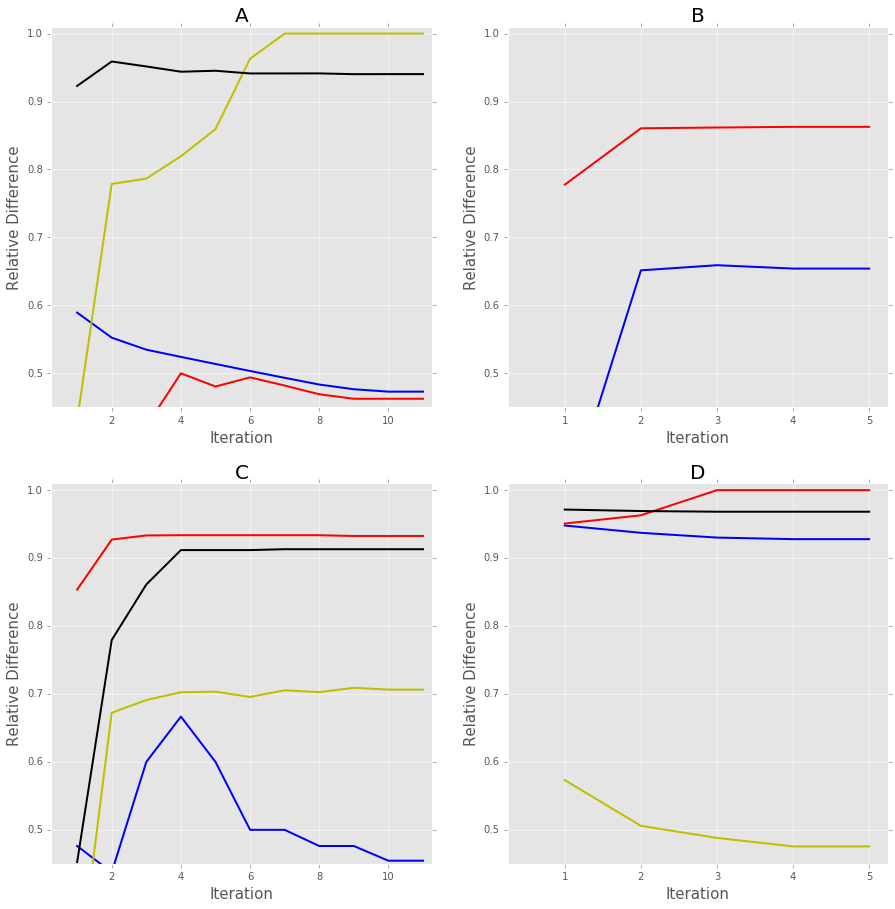

In [208]:
from matplotlib import pyplot as plot
import numpy as np
import re
from sklearn.metrics.pairwise import pairwise_distances

import timeit
%matplotlib inline

k = 4
plot.figure(figsize=(15, 15))

## function loads data from any of the 4 initializations
def loadData(filename):
    relative_diff = {}
    iterations = []
    f = open(filename, 'r')
    for line in f:
        line  = line.strip()
        data = re.split(",",line)
        iterations.append(int(data[0]))
        i = 0
        for i in range(len(data)):
            if i:
                relative_diff.setdefault(i,[])
                relative_diff[i].append(float(data[i])) 
    return relative_diff

## load Relative Difference for initialization A
relative_diff = {}
relative_diff = loadData("relative_diff-A.txt")
iterations = [i+1 for i in range(len(relative_diff[1]))]

## plot Relative Difference for initialization A
plot.subplot(2,2,1)
plot.axis([0.25, max(iterations)+0.25,0.45, 1.01])
plot.plot(iterations,relative_diff[1],'b',lw=2)
plot.plot(iterations,relative_diff[2],'r',lw=2)
plot.plot(iterations,relative_diff[3],'y',lw=2)
plot.plot(iterations,relative_diff[4],'black',lw=2)
plot.xlabel('Iteration',fontsize=15)
plot.ylabel('Relative Difference',fontsize=15)
plot.title("A",fontsize=20)
plot.grid(True)

## load Relative Difference for initialization B
relative_diff = {}
relative_diff = loadData("relative_diff-B.txt")
iterations = [i+1 for i in range(len(relative_diff[1]))]

## plot Relative Difference for initialization B
plot.subplot(2,2,2)
plot.axis([0.25, max(iterations)+0.25,0.45, 1.01])
plot.plot(iterations,relative_diff[1],'b',lw=2)
plot.plot(iterations,relative_diff[2],'r',lw=2)
plot.xlabel('Iteration',fontsize=15)
plot.ylabel('Relative Difference',fontsize=15)
plot.title("B",fontsize=20)
plot.grid(True)

## load Relative Difference for initialization C
relative_diff = {}
relative_diff = loadData("relative_diff-C.txt")
iterations = [i+1 for i in range(len(relative_diff[1]))]

## plot Relative Difference for initialization C
plot.subplot(2,2,3)
plot.axis([0.25, max(iterations)+0.25,0.45, 1.01])
plot.plot(iterations,relative_diff[1],'b',lw=2)
plot.plot(iterations,relative_diff[2],'r',lw=2)
plot.plot(iterations,relative_diff[3],'y',lw=2)
plot.plot(iterations,relative_diff[4],'black',lw=2)
plot.xlabel('Iteration',fontsize=15)
plot.ylabel('Relative Difference',fontsize=15)
plot.title("C",fontsize=20)
plot.grid(True)

## load Relative Difference for initialization D
relative_diff = {}
relative_diff = loadData("relative_diff-D.txt")
iterations = [i+1 for i in range(len(relative_diff[1]))]

## plot Relative Difference for initialization D
plot.subplot(2,2,4)
plot.axis([0.25, max(iterations)+0.25,0.45, 1.01])
plot.plot(iterations,relative_diff[1],'b',lw=2)
plot.plot(iterations,relative_diff[2],'r',lw=2)
plot.plot(iterations,relative_diff[3],'y',lw=2)
plot.plot(iterations,relative_diff[4],'black',lw=2)
plot.xlabel('Iteration',fontsize=15)
plot.ylabel('Relative Difference',fontsize=15)
plot.title("D",fontsize=20)
plot.grid(True)


Discussion

As cases A,B, and C involving some randomization into initialization, leading to results that will be different from different experiment. If one want to compare the randomization initializations with greater confidence, it would be better to run our experiment a number of times, recording relative difference at convergence, the numbers of iterations before convergence, and summarizing these results across runs.

We observe that in those experiments with k=4 (A,B, and D), the trained centroid initializations D converge in the fewest iterations. Moreover, we can see that when D is compared to all other initializations, the top three (relative difference) clusters are generally more concentrate after convergence, indicating that the labeling of users accompanying the data are likely meaningful. Of all of the initializations, we can see that B performs the worst with regard to cluster relative difference. However, this not exactly a fair comparison, as the relative difference measures of 2 clusters with 4 labels is too low---it is not possible to isolate all user types. We must be careful not to mislead ourselves while interpreting these results, as we do not know which user class dominates each cluster. 


# HW4.6  (OPTIONAL) Scaleable K-MEANS++ 

In [221]:
# Prepare
#!/usr/bin/python
from __future__ import division
import os
import sys
import glob
import random
import sklearn
import sklearn.cluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Subplot
%matplotlib inline
plt.style.use('ggplot')

In [237]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
import timeit

# load the raw data
raw_data = np.genfromtxt('topUsers_Apr-Jul_2014_1000-words.txt', delimiter=',')
#print raw_data.shape

data = raw_data[0:1000, 3:1003]

for i in range(0, 1000):
    for j in range(0, 1000):
        data[i][j] = raw_data[i][j+3] / raw_data[i][2]


#print data.shape
#print data[0,]

def KMeansPlusPlus(data, k, l):
    N = data.__len__()
    if k <= 0 or not(isinstance(k,int)) or l <= 0:
        sys.exit()
        
        #  Sample one point uniformly at random from data 
    c = np.array(data[np.random.choice(range(N),1),])
        # To Cost function
    phi = CostFunction(c, data)
        # Looping
    for i in range(np.ceil(np.log(phi)).astype(int)):
        cPrime = data[SamplingProbability(c,data,l) > np.random.uniform(size = N),]
        c = np.concatenate((c, cPrime))

        # For x in C, set w_x to be the number of pts closest to 
    cMini = [np.argmin(np.sum((c-pts)**2,axis=1)) for pts in data];
    closerPts = [cMini.count(i) for i in range(len(c))]
    weight = closerPts/np.sum(closerPts)
        # Re-cluster the weighted points in C into k clusters
    centroid_plus = data[np.random.choice(range(len(c)),size=1,p=weight),]
    data_final = c
    for i in range(k-1):
        Probability = SamplingProbability(centroid_plus,data_final,l) * weight
            # choose next centroid
        cPrimeFin = data[np.random.choice(range(len(c)), size=1, p=Probability/np.sum(Probability)),]
        centroid_plus = np.concatenate((centroid_plus,cPrimeFin))
    start = timeit.default_timer()
    KMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init = centroid_plus, max_iter=500, tol=0.0001)
    KMeansPP.fit(data);
    elapsed_kmeanScalable = timeit.default_timer() - start
    return KMeansPP, centroid_plus, elapsed_kmeanScalable
    
def SamplingProbability(c,data,l):
    cost = CostFunction(c,data)
    return np.array([(min(np.sum((c-pts)**2,axis=1))) * l / cost for pts in data])
    
def CostFunction(c,data):
    return np.sum([min(np.sum((c-pts)**2,axis=1)) for pts in data])
    

KMeansPlusPlus(data, 4, 8)
    

(KMeans(copy_x=True,
     init=array([[  3.88969e-01,   1.59522e-02, ...,   7.51131e-05,   2.62896e-04],
        [  1.34612e-01,   1.32026e-04, ...,   0.00000e+00,   0.00000e+00],
        [  1.34612e-01,   1.32026e-04, ...,   0.00000e+00,   0.00000e+00],
        [  8.63905e-02,   0.00000e+00, ...,   0.00000e+00,   0.00000e+00]]),
     max_iter=500, n_clusters=4, n_init=1, n_jobs=1,
     precompute_distances='auto', random_state=None, tol=0.0001, verbose=0),
 array([[  3.88968697e-01,   1.59521529e-02,   2.75148818e-02, ...,
           0.00000000e+00,   7.51131392e-05,   2.62895987e-04],
        [  1.34611507e-01,   1.32026194e-04,   7.20142876e-06, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  1.34611507e-01,   1.32026194e-04,   7.20142876e-06, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  8.63905325e-02,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00]]),
 0.04352

In [236]:
## Benchmarking for random initial centroids selection

import timeit

# load the raw data
raw_data = np.genfromtxt('topUsers_Apr-Jul_2014_1000-words.txt', delimiter=',')
#print raw_data.shape

data = raw_data[0:1000, 3:1003]

for i in range(0, 1000):
    for j in range(0, 1000):
        data[i][j] = raw_data[i][j+3] / raw_data[i][2]

start = timeit.default_timer()
k = 4
KMeans_random = sklearn.cluster.KMeans(n_clusters=k, init='random', n_init=10, max_iter=500, tol=0.0001)
KMeans_random.fit(data);
elapsed_random = timeit.default_timer() - start
print(elapsed_random)



1.09727907181


#### By using Scalable Kemans++ implementation, the total time for clustering  was improved from 1.097 to 0.043, about 95 % improvement.

# HW4.7   (OPTIONAL) Canopy Clustering

In [317]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
import timeit

# load the raw data
raw_data = np.genfromtxt('topUsers_Apr-Jul_2014_1000-words.txt', delimiter=',')
#print raw_data.shape

data = raw_data[0:1000, 3:1003]

for i in range(0, 1000):
    for j in range(0, 1000):
        data[i][j] = raw_data[i][j+3] / raw_data[i][2]

# X input data matrix

    
def canopy(Y, T1, T2, distance_metric='euclidean', filemap=None):
    canopies = dict()
    centers = []
    Y1_dist = pairwise_distances(Y, metric=distance_metric)
    canopy_points = set(range(Y.shape[0]))
    while canopy_points:
        point = canopy_points.pop()
        i = len(canopies)
        canopies[i] = {"c":point, "points": list(np.where(X1_dist[point] < T2)[0])}
        centers.append(point)
        canopy_points = canopy_points.difference(set(np.where(X1_dist[point] < T1)[0]))
    if filemap:
        for canopy_id in canopies.keys():
            canopy = canopies.pop(canopy_id)
            canopy2 = {"c":filemap[canopy['c']], "points":list()}
            for point in canopy['points']:
                canopy2["points"].append(filemap[point])
            canopies[canopy_id] = canopy2
    return centers

# We need to adjust T1 and T2 to have final canopies number is 4 since there are four codes.

centers = canopy(data, 0.47, 0.1, distance_metric='euclidean', filemap=None)

print 'Data indices for four centroids: ', centers
centroid_canopy = raw_data[0:4, 3:1003]
for i in range(4):
     centroid_canopy[i] = data[centers[i], ]
    
#print centroid_canopy[0]


start = timeit.default_timer()
KMeans_Canopy = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init = centroid_canopy, max_iter=500, tol=0.0001)
KMeans_Canopy.fit(data);
KMeans_Canopy.
elapsed_KMeans_Canopy = timeit.default_timer() - start

print 'Classification time required for Canopy Algorithm: ', elapsed_KMeans_Canopy






Data indices for four centroids:  [0, 10, 538, 922]
Classification time required for Canopy Algorithm:  0.06258893013


#### By using Canopy algorithm for initial centorids selection, the total time for clustering  was improved from 1.097 (random centorids selection) to 0.063, about 93 % improvement.

In [339]:
!./kMeans_driver.py F > relative_diff-F.txt

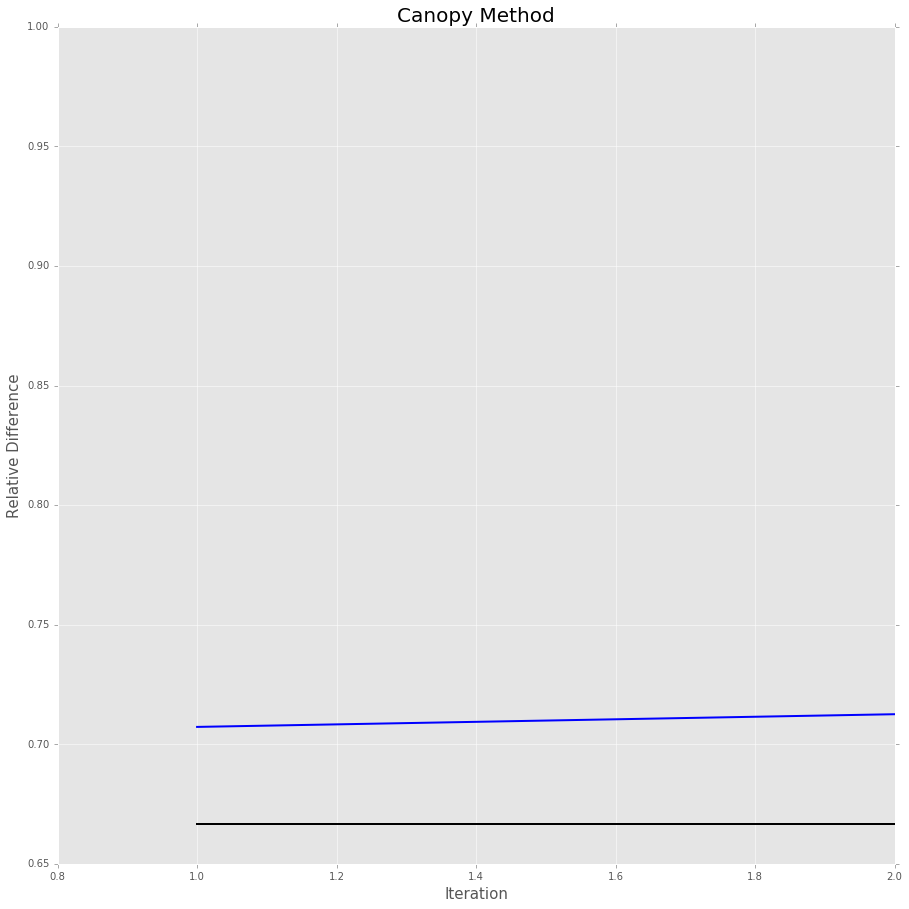

In [341]:
from matplotlib import pyplot as plot
import numpy as np
import re
from sklearn.metrics.pairwise import pairwise_distances

import timeit
%matplotlib inline




k = 4
plot.figure(figsize=(15, 15))

## function loads data from any of the 4 initializations
def loadData(filename):
    relative_diff = {}
    iterations = []
    f = open(filename, 'r')
    for line in f:
        line  = line.strip()
        data = re.split(",",line)
        iterations.append(int(data[0]))
        i = 0
        for i in range(len(data)):
            if i:
                relative_diff.setdefault(i,[])
                relative_diff[i].append(float(data[i])) 
    return relative_diff

## load Relative Difference for initialization A
relative_diff = {}
relative_diff = loadData("relative_diff-F.txt")
iterations = [i+1 for i in range(len(relative_diff[1]))]


plot.plot(iterations,relative_diff[1],'b',lw=2)
plot.plot(iterations,relative_diff[2],'r',lw=2)
plot.plot(iterations,relative_diff[3],'y',lw=2)
plot.plot(iterations,relative_diff[4],'black',lw=2)

plot.xlabel('Iteration',fontsize=15)
plot.ylabel('Relative Difference',fontsize=15)
plot.title("Canopy Method",fontsize=20)
plot.grid(True)

#### Compared to previous A, B, C, D cases, Canopy can converge very quickly. Here, it only spend two times to converge.